In [1]:
import pandas as pd 
import numpy as np 
import csv  
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report,accuracy_score,confusion_matrix,plot_roc_curve



from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate


In [2]:
crashes_data = pd.read_csv('data/Traffic_Crashes_-_Crashes.csv')
crashes_data.info()

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541142 entries, 0 to 541141
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                541142 non-null  object 
 1   RD_NO                          536550 non-null  object 
 2   CRASH_DATE_EST_I               41029 non-null   object 
 3   CRASH_DATE                     541142 non-null  object 
 4   POSTED_SPEED_LIMIT             541142 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         541142 non-null  object 
 6   DEVICE_CONDITION               541142 non-null  object 
 7   WEATHER_CONDITION              541142 non-null  object 
 8   LIGHTING_CONDITION             541142 non-null  object 
 9   FIRST_CRASH_TYPE               541142 non-null  object 
 10  TRAFFICWAY_TYPE                541142 non-null  object 
 11  LANE_CNT                       198968 non-null  float64
 12  ALIGNMENT                     

In [3]:
crashes_data.drop(crashes_data.columns[np.r_[1,2,5,10:13,15,17:20,21,24:35,36:43,48]], axis=1, inplace=True)
crashes_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541142 entries, 0 to 541141
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          541142 non-null  object 
 1   CRASH_DATE               541142 non-null  object 
 2   POSTED_SPEED_LIMIT       541142 non-null  int64  
 3   DEVICE_CONDITION         541142 non-null  object 
 4   WEATHER_CONDITION        541142 non-null  object 
 5   LIGHTING_CONDITION       541142 non-null  object 
 6   FIRST_CRASH_TYPE         541142 non-null  object 
 7   ROADWAY_SURFACE_COND     541142 non-null  object 
 8   ROAD_DEFECT              541142 non-null  object 
 9   CRASH_TYPE               541142 non-null  object 
 10  DAMAGE                   541142 non-null  object 
 11  PRIM_CONTRIBUTORY_CAUSE  541142 non-null  object 
 12  SEC_CONTRIBUTORY_CAUSE   541142 non-null  object 
 13  MOST_SEVERE_INJURY       540019 non-null  object 
 14  CRAS

Exploratory Data Analysis
Step 1: Import and read data
Step 2: Check datatypes
Step 3: Check duplicates
Step 4: Check nulls/missing values
Step 5: Check outliers

In [4]:
people_data = pd.read_csv('data/Traffic_Crashes_-_People.csv')
people_data.info()

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195089 entries, 0 to 1195088
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   PERSON_ID              1195089 non-null  object 
 1   PERSON_TYPE            1195089 non-null  object 
 2   CRASH_RECORD_ID        1195089 non-null  object 
 3   RD_NO                  1184791 non-null  object 
 4   VEHICLE_ID             1171503 non-null  float64
 5   CRASH_DATE             1195089 non-null  object 
 6   SEAT_NO                244372 non-null   float64
 7   CITY                   879272 non-null   object 
 8   STATE                  889722 non-null   object 
 9   ZIPCODE                802767 non-null   object 
 10  SEX                    1177027 non-null  object 
 11  AGE                    851997 non-null   float64
 12  DRIVERS_LICENSE_STATE  705170 non-null   object 
 13  DRIVERS_LICENSE_CLASS  607731 non-null   object 
 14  SAFETY_EQUIPMENT  

In [5]:
people_data = pd.read_csv('data/Traffic_Crashes_-_People.csv')
people_data.drop(people_data.columns[np.r_[3:10,11,12,13,17:30]], axis=1, inplace=True)
people_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195089 entries, 0 to 1195088
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   PERSON_ID         1195089 non-null  object
 1   PERSON_TYPE       1195089 non-null  object
 2   CRASH_RECORD_ID   1195089 non-null  object
 3   SEX               1177027 non-null  object
 4   SAFETY_EQUIPMENT  1191601 non-null  object
 5   AIRBAG_DEPLOYED   1172498 non-null  object
 6   EJECTION          1180555 non-null  object
dtypes: object(7)
memory usage: 63.8+ MB


In [6]:
vehicles_data = pd.read_csv('data/Traffic_Crashes_-_Vehicles.csv')
vehicles_data.info()

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107267 entries, 0 to 1107266
Data columns (total 72 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   CRASH_UNIT_ID             1107267 non-null  int64  
 1   CRASH_RECORD_ID           1107267 non-null  object 
 2   RD_NO                     1097786 non-null  object 
 3   CRASH_DATE                1107267 non-null  object 
 4   UNIT_NO                   1107267 non-null  int64  
 5   UNIT_TYPE                 1105670 non-null  object 
 6   NUM_PASSENGERS            165920 non-null   float64
 7   VEHICLE_ID                1081934 non-null  float64
 8   CMRC_VEH_I                20475 non-null    object 
 9   MAKE                      1081929 non-null  object 
 10  MODEL                     1081786 non-null  object 
 11  LIC_PLATE_STATE           987487 non-null   object 
 12  VEHICLE_YEAR              905696 non-null   float64
 13  VEHICLE_DEFECT            1

In [7]:
vehicles_data.drop(vehicles_data.columns[np.r_[0,2:13,16,18:38,39:72]], axis=1, inplace=True)
vehicles_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107267 entries, 0 to 1107266
Data columns (total 6 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   CRASH_RECORD_ID      1107267 non-null  object
 1   VEHICLE_DEFECT       1081934 non-null  object
 2   VEHICLE_TYPE         1081934 non-null  object
 3   VEHICLE_USE          1081934 non-null  object
 4   MANEUVER             1081934 non-null  object
 5   FIRST_CONTACT_POINT  1073691 non-null  object
dtypes: object(6)
memory usage: 50.7+ MB


In [8]:
people_crashes_data = crashes_data.merge(people_data, on='CRASH_RECORD_ID')
df = people_crashes_data.merge(vehicles_data, on='CRASH_RECORD_ID')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2528859 entries, 0 to 2528858
Data columns (total 30 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   CRASH_RECORD_ID          object 
 1   CRASH_DATE               object 
 2   POSTED_SPEED_LIMIT       int64  
 3   DEVICE_CONDITION         object 
 4   WEATHER_CONDITION        object 
 5   LIGHTING_CONDITION       object 
 6   FIRST_CRASH_TYPE         object 
 7   ROADWAY_SURFACE_COND     object 
 8   ROAD_DEFECT              object 
 9   CRASH_TYPE               object 
 10  DAMAGE                   object 
 11  PRIM_CONTRIBUTORY_CAUSE  object 
 12  SEC_CONTRIBUTORY_CAUSE   object 
 13  MOST_SEVERE_INJURY       object 
 14  CRASH_HOUR               int64  
 15  CRASH_DAY_OF_WEEK        int64  
 16  CRASH_MONTH              int64  
 17  LATITUDE                 float64
 18  LONGITUDE                float64
 19  PERSON_ID                object 
 20  PERSON_TYPE              object 
 21  SEX     

In [9]:
df['MOST_SEVERE_INJURY'] = df['MOST_SEVERE_INJURY'].map({'NO INDICATION OF INJURY': 'mild', 
                                                                         'REPORTED, NOT EVIDENT': 'mild',
                                                                         'NONINCAPACITATING INJURY': 'medium',
                                                                         'INCAPACITATING INJURY': 'severe',
                                                                         'FATAL': 'severe'})
df['MOST_SEVERE_INJURY']

0          mild
1          mild
2          mild
3          mild
4          mild
           ... 
2528854    mild
2528855    mild
2528856    mild
2528857    mild
2528858    mild
Name: MOST_SEVERE_INJURY, Length: 2528859, dtype: object

In [10]:
df.duplicated().sum()

73592

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df['LATITUDE'].fillna(df['LATITUDE'].mean(), inplace=True )
df['LONGITUDE'].fillna(df['LONGITUDE'].mean(), inplace=True )

In [13]:
df.dropna(subset=['MOST_SEVERE_INJURY'], inplace=True)

In [14]:
df['SAFETY_EQUIPMENT'].value_counts()

SAFETY BELT USED                              1216265
USAGE UNKNOWN                                 1094886
NONE PRESENT                                    77017
CHILD RESTRAINT USED                            16187
SAFETY BELT NOT USED                            14150
HELMET NOT USED                                  9452
CHILD RESTRAINT - FORWARD FACING                 4650
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)       3313
HELMET USED                                      2663
CHILD RESTRAINT - TYPE UNKNOWN                   2369
CHILD RESTRAINT - REAR FACING                    2257
DOT COMPLIANT MOTORCYCLE HELMET                  1277
BOOSTER SEAT                                     1225
CHILD RESTRAINT NOT USED                         1215
NOT DOT COMPLIANT MOTORCYCLE HELMET               258
SHOULD/LAP BELT USED IMPROPERLY                   246
WHEELCHAIR                                        229
CHILD RESTRAINT USED IMPROPERLY                   191
STRETCHER                   

In [15]:
df['SEX'].fillna('X', inplace=True)

df['SEX'] = df['SEX'].map({'M': 'M', 
                           'F': 'F',
                           'X': 'Unknown'})
df['SEX'].value_counts()

M          1277919
F           928875
Unknown     248453
Name: SEX, dtype: int64

In [16]:
df['SAFETY_EQUIPMENT'].fillna('USAGE UNKNOWN', inplace=True)
df['AIRBAG_DEPLOYED'].fillna('DEPLOYMENT UNKNOWN', inplace=True)
df['EJECTION'].fillna('UNKNOWN', inplace=True)
df['VEHICLE_DEFECT'].fillna('UNKNOWN', inplace=True)
df['VEHICLE_TYPE'].fillna('UNKNOWN/NA', inplace=True)
df['VEHICLE_USE'].fillna('UNKNOWN/NA', inplace=True)
df['MANEUVER'].fillna('UNKNOWN/NA', inplace=True)
df['FIRST_CONTACT_POINT'].fillna('UNKNOWN', inplace=True)
df


,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ROADWAY_SURFACE_COND,ROAD_DEFECT,CRASH_TYPE,...,PERSON_TYPE,SEX,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,FIRST_CONTACT_POINT
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,07/10/2019 05:56:00 PM,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
1,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,07/10/2019 05:56:00 PM,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT
2,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,07/10/2019 05:56:00 PM,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
3,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,07/10/2019 05:56:00 PM,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT
4,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,07/10/2019 05:56:00 PM,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,PASSENGER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528853,d51aae396db49981c7ee26ceb54dfcab3c4b06d0cc5d7d...,07/12/2021 10:00:00 AM,30,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,DRIVER,M,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NONE,PASSENGER,PERSONAL,STRAIGHT AHEAD,FRONT-LEFT
2528854,d51aae396db49981c7ee26ceb54dfcab3c4b06d0cc5d7d...,07/12/2021 10:00:00 AM,30,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,DRIVER,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR-LEFT
2528855,d51aae396db49981c7ee26ceb54dfcab3c4b06d0cc5d7d...,07/12/2021 10:00:00 AM,30,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,DRIVER,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,NONE,PASSENGER,PERSONAL,STRAIGHT AHEAD,FRONT-LEFT
2528856,c83fa5092963bda54b781bf8cfdd840b5106004afbdd34...,07/13/2021 10:30:00 PM,30,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,DRIVER,F,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,UNKNOWN/NA,TOTAL (ALL AREAS)


In [17]:
df.isnull().sum()

CRASH_RECORD_ID            0
CRASH_DATE                 0
POSTED_SPEED_LIMIT         0
DEVICE_CONDITION           0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
FIRST_CRASH_TYPE           0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
CRASH_TYPE                 0
DAMAGE                     0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
MOST_SEVERE_INJURY         0
CRASH_HOUR                 0
CRASH_DAY_OF_WEEK          0
CRASH_MONTH                0
LATITUDE                   0
LONGITUDE                  0
PERSON_ID                  0
PERSON_TYPE                0
SEX                        0
SAFETY_EQUIPMENT           0
AIRBAG_DEPLOYED            0
EJECTION                   0
VEHICLE_DEFECT             0
VEHICLE_TYPE               0
VEHICLE_USE                0
MANEUVER                   0
FIRST_CONTACT_POINT        0
dtype: int64

In [18]:
import datetime as datetime
df['CRASH_DATE'] = df['CRASH_DATE'].map(lambda x: datetime.datetime.strptime(x[0:10], "%m/%d/%Y"))
df['CRASH_DATE']

0         2019-07-10
1         2019-07-10
2         2019-07-10
3         2019-07-10
4         2019-07-10
             ...    
2528853   2021-07-12
2528854   2021-07-12
2528855   2021-07-12
2528856   2021-07-13
2528857   2021-07-13
Name: CRASH_DATE, Length: 2455247, dtype: datetime64[ns]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2455247 entries, 0 to 2528857
Data columns (total 30 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   CRASH_RECORD_ID          object        
 1   CRASH_DATE               datetime64[ns]
 2   POSTED_SPEED_LIMIT       int64         
 3   DEVICE_CONDITION         object        
 4   WEATHER_CONDITION        object        
 5   LIGHTING_CONDITION       object        
 6   FIRST_CRASH_TYPE         object        
 7   ROADWAY_SURFACE_COND     object        
 8   ROAD_DEFECT              object        
 9   CRASH_TYPE               object        
 10  DAMAGE                   object        
 11  PRIM_CONTRIBUTORY_CAUSE  object        
 12  SEC_CONTRIBUTORY_CAUSE   object        
 13  MOST_SEVERE_INJURY       object        
 14  CRASH_HOUR               int64         
 15  CRASH_DAY_OF_WEEK        int64         
 16  CRASH_MONTH              int64         
 17  LATITUDE                 fl

In [20]:
df["CRASH_DATE"].isin(pd.date_range("2019-01-01", "2020-01-01"))
# df['CRASH_DATE']

0           True
1           True
2           True
3           True
4           True
           ...  
2528853    False
2528854    False
2528855    False
2528856    False
2528857    False
Name: CRASH_DATE, Length: 2455247, dtype: bool

In [21]:
df= df[df["CRASH_DATE"].isin(pd.date_range("2019-01-01", "2020-01-01"))]

df

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ROADWAY_SURFACE_COND,ROAD_DEFECT,CRASH_TYPE,...,PERSON_TYPE,SEX,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,FIRST_CONTACT_POINT
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
1,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT
2,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
3,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT
4,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,PASSENGER,M,USAGE UNKNOWN,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528207,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,PICKUP,UNKNOWN/NA,TURNING RIGHT,REAR-LEFT
2528208,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,M,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,UNKNOWN/NA,PERSONAL,TURNING LEFT,SIDE-RIGHT
2528209,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,UNKNOWN,PICKUP,UNKNOWN/NA,TURNING RIGHT,REAR-LEFT
2528210,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DRIVER,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,UNKNOWN,UNKNOWN/NA,PERSONAL,TURNING LEFT,SIDE-RIGHT


In [22]:

import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline
import descartes

<AxesSubplot:>

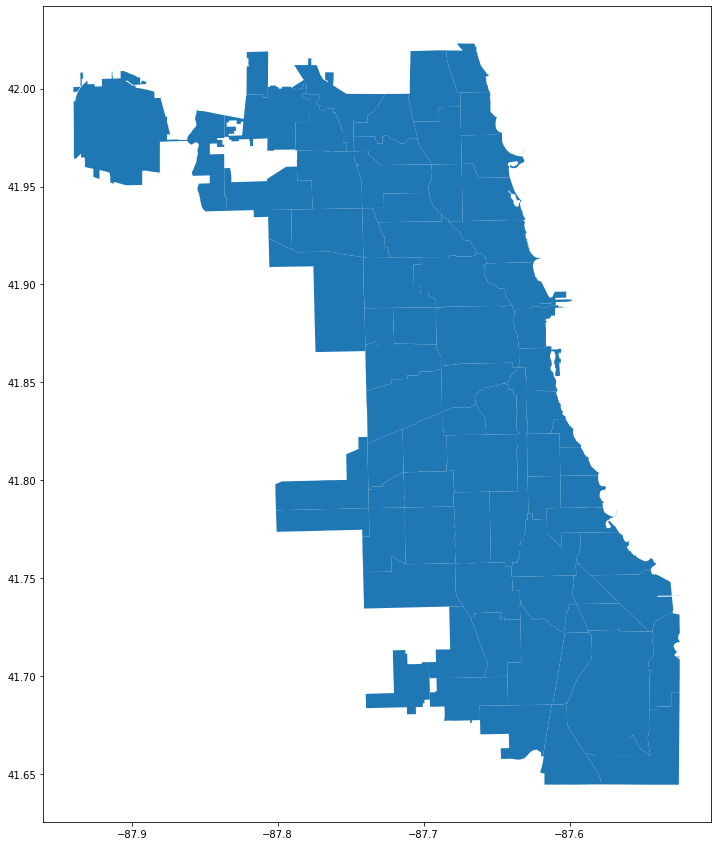

In [23]:
street_map = gpd.read_file('data/street_center_lines/geo_export_1cf411cc-3964-4b23-a824-9e05b1386235.shp')
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax)


In [24]:
crs = {'init': 'epsg:4326'}
geo = [Point(xy) for xy in zip( df["LONGITUDE"], df["LATITUDE"])]
geo[:3]

In [37]:
geo_df = gpd.GeoDataFrame(df, crs=crs,  geometry=geo )
geo_df = geo_df[geo_df['LONGITUDE'] != 0.0]
geo_df.info()

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 543229 entries, 0 to 2528233
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_RECORD_ID          543229 non-null  object        
 1   CRASH_DATE               543229 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT       543229 non-null  int64         
 3   DEVICE_CONDITION         543229 non-null  object        
 4   WEATHER_CONDITION        543229 non-null  object        
 5   LIGHTING_CONDITION       543229 non-null  object        
 6   FIRST_CRASH_TYPE         543229 non-null  object        
 7   ROADWAY_SURFACE_COND     543229 non-null  object        
 8   ROAD_DEFECT              543229 non-null  object        
 9   CRASH_TYPE               543229 non-null  object        
 10  DAMAGE                   543229 non-null  object        
 11  PRIM_CONTRIBUTORY_CAUSE  543229 non-null  object        
 12  SEC_CON

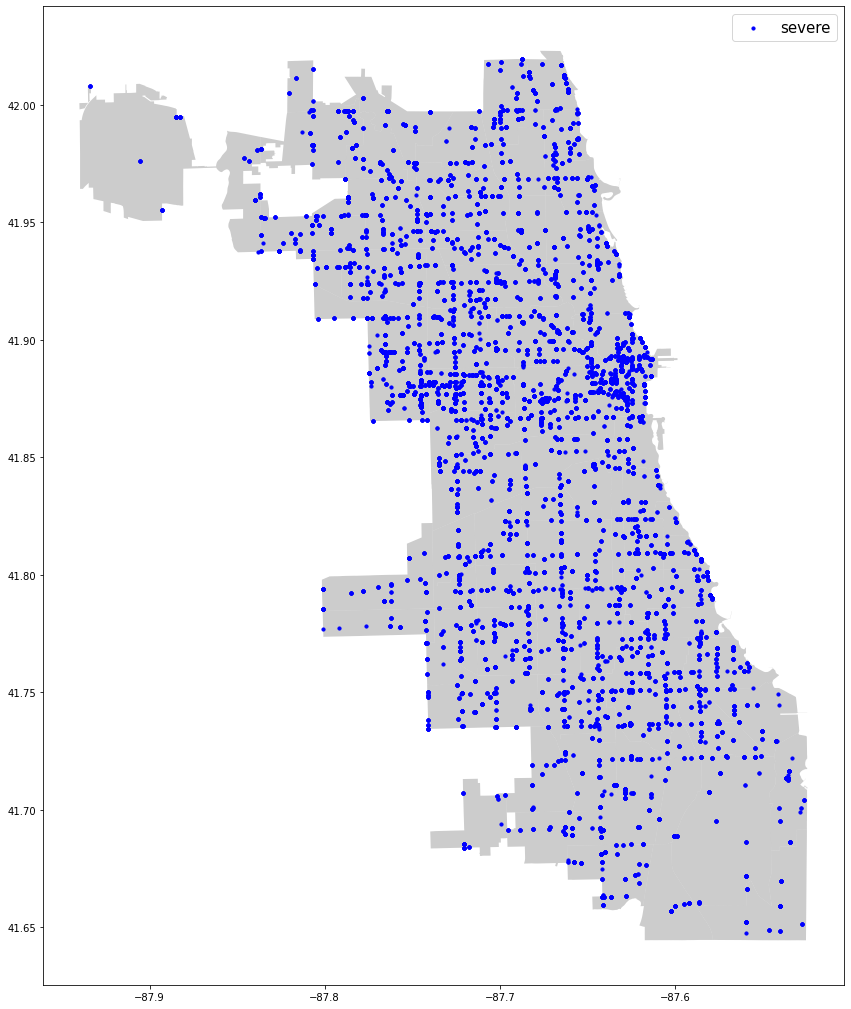

In [41]:
fig, ax = plt.subplots(figsize = (18,18))
street_map.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df[geo_df['MOST_SEVERE_INJURY'] == 'severe'].plot(ax = ax, 
                                                        markersize = 10, 
                                                        color = 'blue', 
                                                        marker = 'o', 
                                                        label = 'severe')



plt.legend(prop = {'size':15})

In [42]:
geo_df['VEHICLE_TYPE'].value_counts()

PASSENGER                                 341088
SPORT UTILITY VEHICLE (SUV)                72892
UNKNOWN/NA                                 51048
VAN/MINI-VAN                               28401
PICKUP                                     15800
TRUCK - SINGLE UNIT                         9704
BUS OVER 15 PASS.                           8653
OTHER                                       5613
TRACTOR W/ SEMI-TRAILER                     4780
BUS UP TO 15 PASS.                          1396
MOTORCYCLE (OVER 150CC)                     1110
SINGLE UNIT TRUCK WITH TRAILER               943
TRACTOR W/O SEMI-TRAILER                     809
OTHER VEHICLE WITH TRAILER                   670
MOPED OR MOTORIZED BICYCLE                   113
AUTOCYCLE                                    108
ALL-TERRAIN VEHICLE (ATV)                     30
MOTOR DRIVEN CYCLE                            28
FARM EQUIPMENT                                26
3-WHEELED MOTORCYCLE (2 REAR WHEELS)          14
RECREATIONAL OFF-HIG

In [43]:
step  = 0.01
to_bin = lambda x: np.floor(x / step ) * step 
geo_df["latbin"] = geo_df['LATITUDE'].map(to_bin)
geo_df["latbin"]
geo_df["lonbin"] = geo_df['LONGITUDE'].map(to_bin)
geo_df


,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,ROADWAY_SURFACE_COND,ROAD_DEFECT,CRASH_TYPE,...,AIRBAG_DEPLOYED,EJECTION,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,FIRST_CONTACT_POINT,geometry,latbin,lonbin
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR,POINT (-87.77329 41.91966),41.91,-87.78
1,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT,POINT (-87.77329 41.91966),41.91,-87.78
2,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR,POINT (-87.77329 41.91966),41.91,-87.78
3,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,TURNING RIGHT,FRONT,POINT (-87.77329 41.91966),41.91,-87.78
4,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NOT APPLICABLE,NONE,UNKNOWN,PASSENGER,PERSONAL,BACKING,REAR,POINT (-87.77329 41.91966),41.91,-87.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528207,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,PICKUP,UNKNOWN/NA,TURNING RIGHT,REAR-LEFT,POINT (-87.70523 41.85817),41.85,-87.71
2528208,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DEPLOYMENT UNKNOWN,NONE,UNKNOWN,UNKNOWN/NA,PERSONAL,TURNING LEFT,SIDE-RIGHT,POINT (-87.70523 41.85817),41.85,-87.71
2528209,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DID NOT DEPLOY,NONE,UNKNOWN,PICKUP,UNKNOWN/NA,TURNING RIGHT,REAR-LEFT,POINT (-87.70523 41.85817),41.85,-87.71
2528210,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",TURNING,WET,NO DEFECTS,NO INJURY / DRIVE AWAY,...,DID NOT DEPLOY,NONE,UNKNOWN,UNKNOWN/NA,PERSONAL,TURNING LEFT,SIDE-RIGHT,POINT (-87.70523 41.85817),41.85,-87.71


/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
No handles with labels found to put in legend.


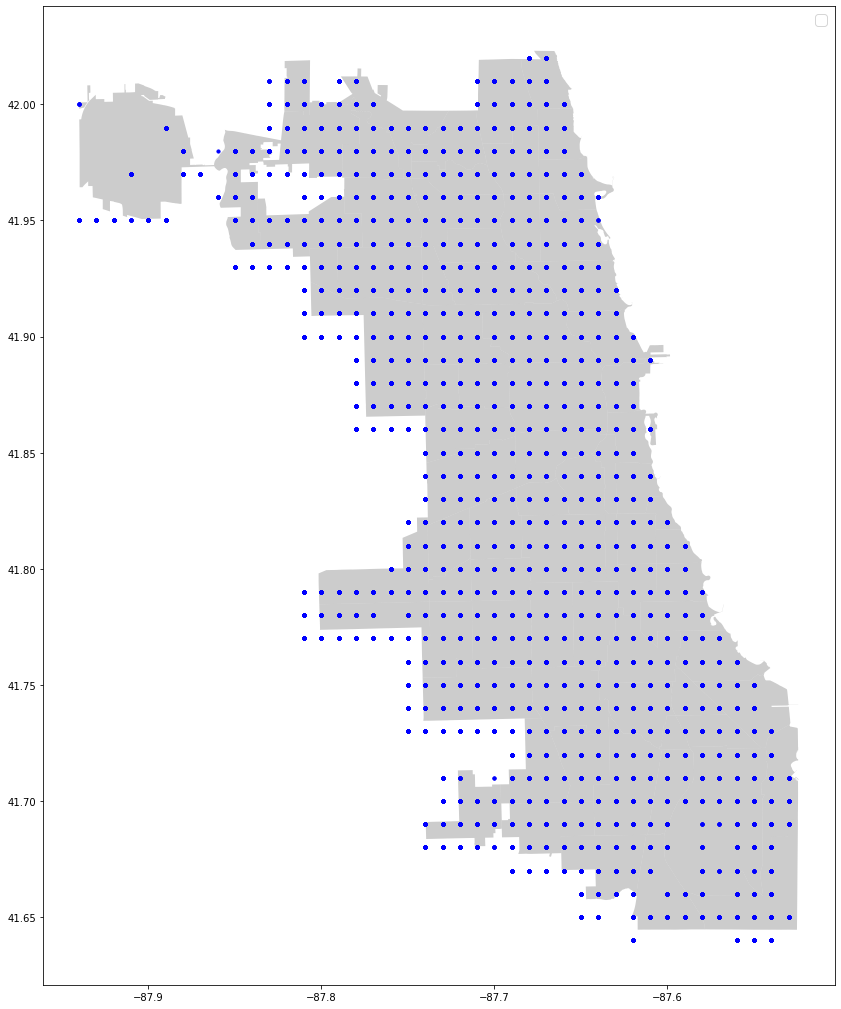

In [44]:
geo_bin = [Point(xy) for xy in zip( geo_df["lonbin"], geo_df["latbin"])]
geo_df_bin = gpd.GeoDataFrame(geo_df, crs=crs,  geometry=geo_bin )

fig, ax = plt.subplots(figsize = (18,18))
street_map.plot(ax = ax, alpha = 0.4, color = 'grey')
geo_df.plot(ax = ax, markersize = 10, color = 'blue', marker = 'o')


plt.legend(prop = {'size':15})




In [45]:
geo_bin = pd.DataFrame(geo_df[["lonbin","latbin"]].value_counts())
geo_bin.reset_index(inplace=True)
geo_bin['accident_count'] = geo_bin[0] 
geo_bin['accident_prob'] = 100*(geo_bin['accident_count']/geo_bin['accident_count'].sum())
print(geo_bin['accident_count'].quantile(.8) )     
print(geo_bin['accident_count'].quantile(.6) )     
print(geo_bin['accident_count'].quantile(.4) )     
print(geo_bin['accident_count'].quantile(.2) )     
      

1229.0
816.0
466.0
167.0


In [53]:
geo_bin['accident_risk'] = geo_bin['accident_count'].map(lambda x: label_zones(x))

In [54]:
df_map = geo_df.merge(geo_bin, how = 'left', on = ['lonbin','latbin'])
geo_bin

,lonbin,latbin,0,accident_count,accident_prob,accident_risk
0,-87.63,41.89,7732,7732,1.423341,5.0
1,-87.63,41.88,7511,7511,1.382658,5.0
2,-87.64,41.89,6484,6484,1.193603,5.0
3,-87.64,41.88,6338,6338,1.166727,5.0
4,-87.68,41.85,5547,5547,1.021116,5.0
...,...,...,...,...,...,...
691,-87.94,42.00,4,4,0.000736,1.0
692,-87.58,41.69,4,4,0.000736,1.0
693,-87.64,41.95,3,3,0.000552,1.0
694,-87.70,41.71,2,2,0.000368,1.0


In [55]:
def label_zones(accident_count):
    if accident_count > 1229.0:
        return 5
    if accident_count < 1229.0 and accident_count > 816.0:
        return 4
    if accident_count < 816.0 and accident_count > 466.0:
        return 3
    if accident_count < 466.0 and accident_count > 167.0:
        return 2
    if accident_count < 167.0:
        return 1  

<AxesSubplot:title={'center':'Accident Likelihood by Area'}>

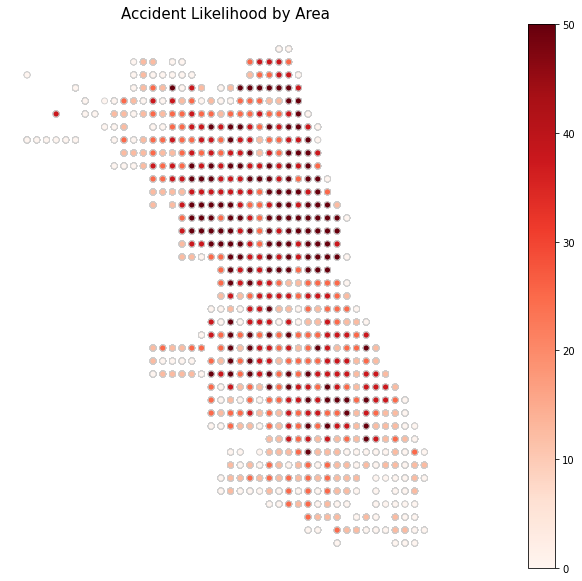

In [57]:
# set the value column that will be visualised
variable = 'accident_risk'
# set the range for the choropleth values
vmin, vmax = 0, 50
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Accident Likelihood by Area', fontdict={'fontsize': '15', 'fontweight' : '3'})

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)
# create map
df_map.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')


In [70]:
df = geo_df.merge(geo_bin, how = 'left', on = ['lonbin','latbin'])
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 543229 entries, 0 to 543228
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_RECORD_ID          543229 non-null  object        
 1   CRASH_DATE               543229 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT       543229 non-null  int64         
 3   DEVICE_CONDITION         543229 non-null  object        
 4   WEATHER_CONDITION        543229 non-null  object        
 5   LIGHTING_CONDITION       543229 non-null  object        
 6   FIRST_CRASH_TYPE         543229 non-null  object        
 7   ROADWAY_SURFACE_COND     543229 non-null  object        
 8   ROAD_DEFECT              543229 non-null  object        
 9   CRASH_TYPE               543229 non-null  object        
 10  DAMAGE                   543229 non-null  object        
 11  PRIM_CONTRIBUTORY_CAUSE  543229 non-null  object        
 12  SEC_CONT

In [71]:
df.drop(df.columns[np.r_[3:6,7,9:13,17:23,24:34,35]], axis=1, inplace=True)
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 543229 entries, 0 to 543228
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CRASH_RECORD_ID     543229 non-null  object        
 1   CRASH_DATE          543229 non-null  datetime64[ns]
 2   POSTED_SPEED_LIMIT  543229 non-null  int64         
 3   FIRST_CRASH_TYPE    543229 non-null  object        
 4   ROAD_DEFECT         543229 non-null  object        
 5   MOST_SEVERE_INJURY  543229 non-null  object        
 6   CRASH_HOUR          543229 non-null  int64         
 7   CRASH_DAY_OF_WEEK   543229 non-null  int64         
 8   CRASH_MONTH         543229 non-null  int64         
 9   AIRBAG_DEPLOYED     543229 non-null  object        
 10  accident_count      543229 non-null  int64         
 11  accident_risk       540551 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 53.9+ MB


In [127]:
df

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,FIRST_CRASH_TYPE,ROAD_DEFECT,MOST_SEVERE_INJURY,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,AIRBAG_DEPLOYED,accident_count,accident_risk,injury_level
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,TURNING,NO DEFECTS,0,17,4,7,NOT APPLICABLE,441,2.0,NaN
1,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,TURNING,NO DEFECTS,0,17,4,7,NOT APPLICABLE,441,2.0,NaN
2,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,TURNING,NO DEFECTS,0,17,4,7,NOT APPLICABLE,441,2.0,NaN
3,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,TURNING,NO DEFECTS,0,17,4,7,NOT APPLICABLE,441,2.0,NaN
4,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,2019-07-10,35,TURNING,NO DEFECTS,0,17,4,7,NOT APPLICABLE,441,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
543224,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,TURNING,NO DEFECTS,0,21,4,6,DEPLOYMENT UNKNOWN,1353,5.0,NaN
543225,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,TURNING,NO DEFECTS,0,21,4,6,DEPLOYMENT UNKNOWN,1353,5.0,NaN
543226,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,TURNING,NO DEFECTS,0,21,4,6,DID NOT DEPLOY,1353,5.0,NaN
543227,ffff27f5ef6d4465bf2e6da46c1d07ac6f017c6ca1f477...,2019-06-19,25,TURNING,NO DEFECTS,0,21,4,6,DID NOT DEPLOY,1353,5.0,NaN


In [128]:
df_graph = df
df_graph = df_graph[(df_graph['ROAD_DEFECT']!='NO DEFECTS')
                   & (df_graph['ROAD_DEFECT']!='OTHER') 
                    & (df_graph['ROAD_DEFECT']!='UNKNOWN')
                   &(df_graph['injury_level']==2)]

df_graph

,CRASH_RECORD_ID,CRASH_DATE,POSTED_SPEED_LIMIT,FIRST_CRASH_TYPE,ROAD_DEFECT,MOST_SEVERE_INJURY,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,AIRBAG_DEPLOYED,accident_count,accident_risk,injury_level


In [124]:
df_graph['injury_level'] = df_graph['MOST_SEVERE_INJURY'].map({'mild': 0, 
                                                         'medium': 1,
                                                         'severe': 2})

In [120]:
df_graph = df_graph.groupby('ROAD_DEFECT')['CRASH_RECORD_ID'].count()
df_graph = pd.DataFrame(df_graph)
df_graph.reset_index(inplace=True)
df_graph.sort_values(by="CRASH_RECORD_ID",ascending = False, inplace=True)

df_graph

,ROAD_DEFECT,CRASH_RECORD_ID


In [121]:
df_graph['CRASH_RECORD_ID']

Series([], Name: CRASH_RECORD_ID, dtype: int64)

Text(0.5, 0, 'Road Defect')

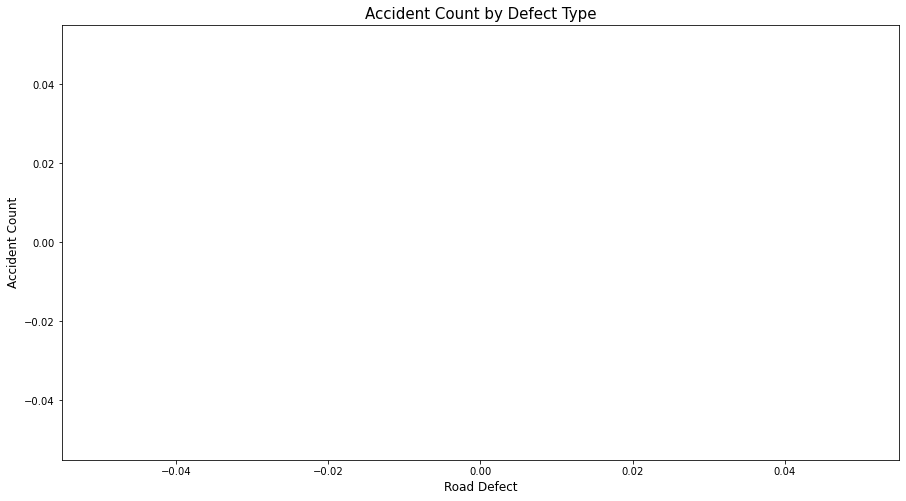

In [114]:
fig, ax = plt.subplots(figsize = (15,8))

x = df_graph['ROAD_DEFECT']
h = df_graph['CRASH_RECORD_ID'] 
ax.bar(x,h, alpha = 0.4, color = 'red')
ax.set_title("Accident Count by Defect Type", fontsize=15)
ax.set_ylabel("Accident Count", fontsize=12)
ax.set_xlabel("Road Defect", fontsize=12)

In [78]:
df_graph1 = df
df_graph1['injury_level'] = df_graph1['MOST_SEVERE_INJURY'].map({'mild': 0, 
                                                         'medium': 1,
                                                         'severe': 2})
df_graph1 = df_graph1[(df_graph1['injury_level']==2)
                     &(df_graph1['AIRBAG_DEPLOYED']!='NOT APPLICABLE')
                     &(df_graph1['AIRBAG_DEPLOYED']!='DEPLOYMENT UNKNOWN')]


In [79]:
df_graph1 = df_graph1.groupby('AIRBAG_DEPLOYED')['CRASH_RECORD_ID'].count()
df_graph1 = pd.DataFrame(df_graph1)
df_graph1.reset_index(inplace=True)
df_graph1.sort_values(by="CRASH_RECORD_ID",ascending = False, inplace=True)
df_graph1

,AIRBAG_DEPLOYED,CRASH_RECORD_ID
4,DID NOT DEPLOY,4722
1,"DEPLOYED, COMBINATION",1422
2,"DEPLOYED, FRONT",1412
3,"DEPLOYED, SIDE",295
0,"DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)",33


Text(0, 0.5, 'Accident Count')

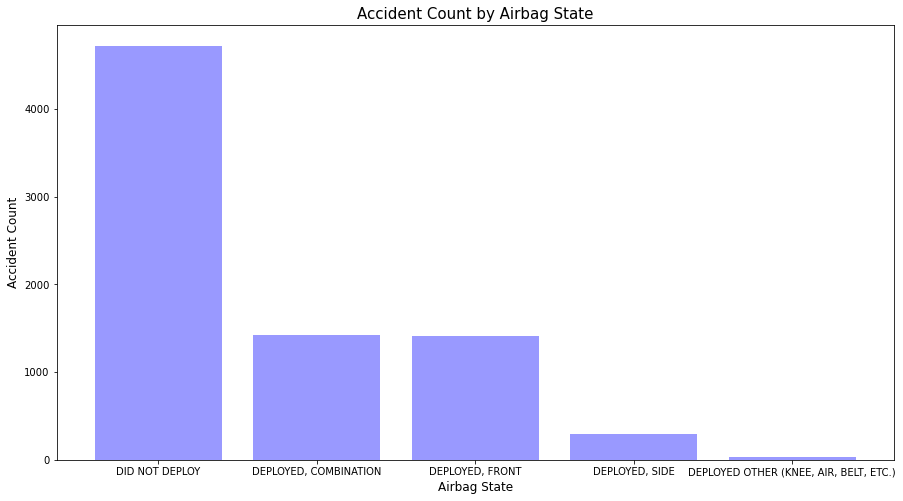

In [105]:
fig, ax = plt.subplots(figsize = (15,8))

x = df_graph1['AIRBAG_DEPLOYED']
h = df_graph1['CRASH_RECORD_ID']
ax.bar(x,h, alpha = 0.4, color = 'blue', )
ax.set_title("Accident Count by Airbag State", fontsize=15)
ax.set_xlabel("Airbag State", fontsize=12)
ax.set_ylabel("Accident Count", fontsize=12)

# Train Test Split

In [81]:
X = df.drop(["MOST_SEVERE_INJURY","CRASH_RECORD_ID", "CRASH_DATE"], axis=1)
X.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 543229 entries, 0 to 543228
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   POSTED_SPEED_LIMIT  543229 non-null  int64  
 1   FIRST_CRASH_TYPE    543229 non-null  object 
 2   ROAD_DEFECT         543229 non-null  object 
 3   CRASH_HOUR          543229 non-null  int64  
 4   CRASH_DAY_OF_WEEK   543229 non-null  int64  
 5   CRASH_MONTH         543229 non-null  int64  
 6   AIRBAG_DEPLOYED     543229 non-null  object 
 7   accident_count      543229 non-null  int64  
 8   accident_risk       540551 non-null  float64
 9   injury_level        543229 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 45.6+ MB


In [82]:
df['MOST_SEVERE_INJURY'] = df['MOST_SEVERE_INJURY'].map({'mild': 0, 
                                                         'medium': 1,
                                                         'severe': 2})
y = df['MOST_SEVERE_INJURY']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 42, stratify=y)

In [84]:
y.value_counts()

0    473724
1     56285
2     13220
Name: MOST_SEVERE_INJURY, dtype: int64

In [85]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [86]:
X_train['AIRBAG_DEPLOYED'].fillna('DEPLOYMENT UNKNOWN', inplace=True)
X_train['accident_risk'].fillna(4, inplace=True)
X_train['accident_count'].fillna(X_train['accident_count'].mean(), inplace=True)

/Users/lorelablaka/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [87]:
X_train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 380260 entries, 469268 to 307969
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   POSTED_SPEED_LIMIT  380260 non-null  int64  
 1   FIRST_CRASH_TYPE    380260 non-null  object 
 2   ROAD_DEFECT         380260 non-null  object 
 3   CRASH_HOUR          380260 non-null  int64  
 4   CRASH_DAY_OF_WEEK   380260 non-null  int64  
 5   CRASH_MONTH         380260 non-null  int64  
 6   AIRBAG_DEPLOYED     380260 non-null  object 
 7   accident_count      380260 non-null  int64  
 8   accident_risk       380260 non-null  float64
 9   injury_level        380260 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 31.9+ MB


# Baseline-dummy_model

In [88]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [89]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)
dummy_model.predict(X_train)[:50]
cv_results = cross_validate(dummy_model, X_train, y_train, return_train_score=True)

print('Mean Train Score: {}'.format(cv_results['train_score'].mean()))

Mean Train Score: 0.8720533319307842


In [90]:
X_train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 380260 entries, 469268 to 307969
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   POSTED_SPEED_LIMIT  380260 non-null  int64  
 1   FIRST_CRASH_TYPE    380260 non-null  object 
 2   ROAD_DEFECT         380260 non-null  object 
 3   CRASH_HOUR          380260 non-null  int64  
 4   CRASH_DAY_OF_WEEK   380260 non-null  int64  
 5   CRASH_MONTH         380260 non-null  int64  
 6   AIRBAG_DEPLOYED     380260 non-null  object 
 7   accident_count      380260 non-null  int64  
 8   accident_risk       380260 non-null  float64
 9   injury_level        380260 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 31.9+ MB


In [91]:
X_train['AIRBAG_DEPLOYED'].value_counts()

DID NOT DEPLOY                            214670
DEPLOYMENT UNKNOWN                         74870
NOT APPLICABLE                             68991
DEPLOYED, FRONT                            11312
DEPLOYED, COMBINATION                       7171
DEPLOYED, SIDE                              3116
DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)       130
Name: AIRBAG_DEPLOYED, dtype: int64

# One Hot Encode

In [92]:
categoricals = ['ROAD_DEFECT',
                'FIRST_CRASH_TYPE', 
                'AIRBAG_DEPLOYED']

train_dummies = X_train[categoricals]
#test_dummies = X_test[categoricals]

# Create OneHotEncoder object to create dummies
ohe = OneHotEncoder(handle_unknown='ignore')
# Transform the dataset into dummies matrix

enc = ohe.fit(train_dummies)
train_dummies_trans = enc.transform(train_dummies)
#test_dummies_trans = enc.transform(test_dummies)

# Dummies values in matrix form
train_data = train_dummies_trans.todense()
#test_data = test_dummies_trans.todense()

# New dummy column names
names = ohe.get_feature_names(categoricals)

# Make them into Dataframe
train_dummies_trans_df = pd.DataFrame(train_data, columns=names,index = X_train.index)
#test_dummies_trans_df = pd.DataFrame(test_data, columns=names)

train_dummies_trans_df

# left_index/right_index = True


,ROAD_DEFECT_DEBRIS ON ROADWAY,ROAD_DEFECT_NO DEFECTS,ROAD_DEFECT_OTHER,"ROAD_DEFECT_RUT, HOLES",ROAD_DEFECT_SHOULDER DEFECT,ROAD_DEFECT_UNKNOWN,ROAD_DEFECT_WORN SURFACE,FIRST_CRASH_TYPE_ANGLE,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,...,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,FIRST_CRASH_TYPE_TRAIN,FIRST_CRASH_TYPE_TURNING,"AIRBAG_DEPLOYED_DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)","AIRBAG_DEPLOYED_DEPLOYED, COMBINATION","AIRBAG_DEPLOYED_DEPLOYED, FRONT","AIRBAG_DEPLOYED_DEPLOYED, SIDE",AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN,AIRBAG_DEPLOYED_DID NOT DEPLOY,AIRBAG_DEPLOYED_NOT APPLICABLE
469268,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
147190,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
271259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
236546,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
348900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10863,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
500326,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
190290,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
111730,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [93]:
numerical = X_train.select_dtypes(exclude='object') 
numerical = pd.DataFrame(numerical, index = X_train.index)
train_df = train_dummies_trans_df.merge(numerical, left_index = True , right_index=True)
train_df

,ROAD_DEFECT_DEBRIS ON ROADWAY,ROAD_DEFECT_NO DEFECTS,ROAD_DEFECT_OTHER,"ROAD_DEFECT_RUT, HOLES",ROAD_DEFECT_SHOULDER DEFECT,ROAD_DEFECT_UNKNOWN,ROAD_DEFECT_WORN SURFACE,FIRST_CRASH_TYPE_ANGLE,FIRST_CRASH_TYPE_ANIMAL,FIRST_CRASH_TYPE_FIXED OBJECT,...,AIRBAG_DEPLOYED_DEPLOYMENT UNKNOWN,AIRBAG_DEPLOYED_DID NOT DEPLOY,AIRBAG_DEPLOYED_NOT APPLICABLE,POSTED_SPEED_LIMIT,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,accident_count,accident_risk,injury_level
469268,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,30,18,5,1,871,4.0,0
147190,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,25,20,3,12,1587,5.0,0
271259,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,30,12,7,9,753,3.0,0
236546,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,30,18,6,12,243,2.0,0
348900,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,30,16,2,1,1109,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10863,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,30,13,7,6,1835,5.0,0
500326,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,30,12,2,5,466,4.0,0
190290,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,30,21,7,10,2290,5.0,0
111730,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,30,10,2,5,1802,5.0,0


# Logistic Model - 1

In [94]:
model_1 = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000000)
X_train_baseline = train_df

# fit the model
model_1.fit(X_train_baseline,y_train)

KeyboardInterrupt: 

In [ ]:
y_hat = model_1.predict(X_train_baseline)

Model 1 Validation

In [ ]:
acc = accuracy_score(y_train,y_hat)
macro_precision_score=precision_score(y_train, y_hat, average='macro')
micro_precision_score=precision_score(y_train, y_hat, average='micro')
macro_recall_score=recall_score(y_train, y_hat, average='macro')
micro_recall_score=recall_score(y_train, y_hat, average='micro')



In [ ]:
print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))



In [ ]:
cv_results = cross_validate(model_1, train_dummies_trans_df, y_train, return_train_score=True)

print('Mean Test Score: {}'.format(cv_results['test_score'].mean()))
print('Mean Train Score: {}'.format(cv_results['train_score'].mean()))

# Lasso

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=100, random_state=42)


In [ ]:
lasso.fit(X_train_baseline, y_train)

In [ ]:
lasso.score(X_train_baseline, y_train)

In [ ]:
cv_results = cross_validate(
                X=X_train_baseline, 
                y=y_train,
                estimator=lasso, 
                cv=10,
                scoring=('precision_macro', 'precision_micro',),
                return_train_score=True
) 

# Decision Tree

In [ ]:
tree_clf = DecisionTreeClassifier(max_depth=2) 

tree_clf.fit(X_train_baseline, y_train)

y_pred_dt = tree_clf.predict(X_train_baseline)
y_pred_dt

In [ ]:
acc = accuracy_score(y_train,y_pred_dt) * 100
print("Accuracy: {0}".format(acc))

In [ ]:
precision_score(y_train, y_pred_dt, average='macro')

In [ ]:
precision_score(y_train, y_pred_dt, average='micro')

In [ ]:
precision_score(y_train, y_pred_dt, average='weighted')

In [ ]:
f,ax = plt.subplots(figsize=(10,10))
plot_tree(tree_clf, ax=ax);

# Random Forest

In [ ]:
# random forest for feature importance on a regression problem
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# define the model
model = RandomForestRegressor()

# fit the model
model.fit(X_train_baseline, y_train)


In [ ]:
# get importance
importance = model.feature_importances_


In [ ]:
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# XG Boost

In [ ]:
from xgboost import XGBRegressor

# define the model
model = XGBRegressor()
# fit the model
model.fit(X_train_baseline, y_train)

In [ ]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

In [ ]:
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
lr_pipline = Pipeline(steps=[('model', LogisticRegression(random_state=42))])
grid = {'model__C' : [0.0001,0.001,0.01,0.1,1],
       'model__max_iter' : [10000, 30000],
       'model__class_weight': [None, 'balanced', 0.25],
       'model__tol' : [0.0001, 0.01, 0.1]}
gridsearch = GridSearchCV(lr_pipline, grid, cv=3, return_train_score=True)
gridsearch.fit(train_dummies_trans_df, y_train)